# MNIST with Bayesian Feed-forward Neural Networks

In [127]:
from warnings import filterwarnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pymc3.variational.callbacks import CheckParametersConvergence
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as T
from tensorflow import keras
from scipy.stats import mode
from sklearn.metrics import accuracy_score

%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")
sns.set_palette("muted")

First we load the MNIST data. For convenience sake we use `tensorflow.keras` here which has provides the MNIST data set via `keras.datasets.mnist.load_data()`. The input data sets `X_train` and `X_test` contain the pixel data for the handwritten digit in form of an image of shape `(28,28)` . We flatten data data to obtain a `(1, 784)` image array and normalise it by dividing by 255. Normalising the data is very important because we will train the Bayesian Neural Network (BNN) via Variational Inference (VI). The Variational Inference relies in part on the Kullback-Leibler divergence (KL-divergence) as its loss function which will be huge for non-normalised values hindering convergence. The labels `Y_train` and `Y_test` are integers between `0` and `9` which we need to convert to floats for variational inference.

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = (X_train.reshape(-1, 28**2) / 255.).astype(floatX)
X_test = (X_test.reshape(-1, 28**2) / 255.).astype(floatX)
Y_train = Y_train.astype(floatX)
Y_test = Y_test.astype(floatX)

The first 20 digits together with the corresponding labels are plotted below.

Text(0.5, 0.98, 'Training data and corresponding labels')

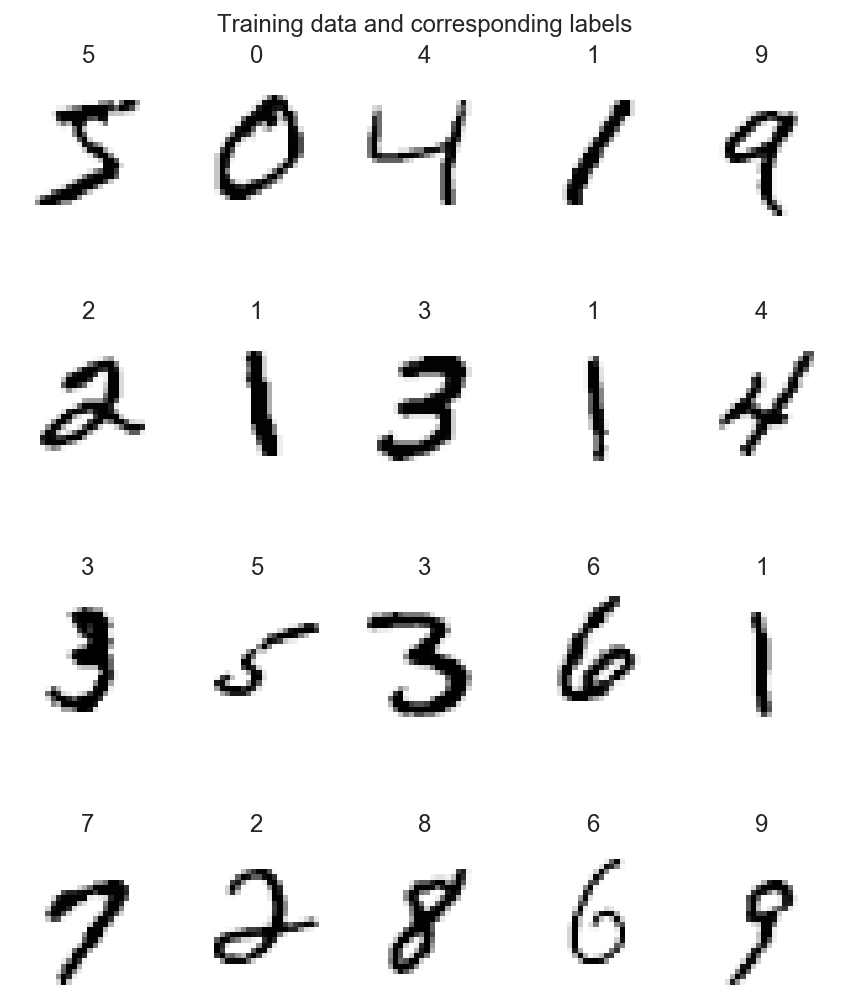

In [147]:
fig, ax = plt.subplots(4,5, figsize=(6,7.5))
for i in range(20):
    ax[i//5, i % 5].imshow(X_train[i].reshape(28, 28), cmap="Greys")
    ax[i//5, i % 5].axis("off")
    ax[i//5, i % 5].set_title(int(Y_train[i]))
    
fig.tight_layout()
fig.suptitle("Training data and corresponding labels")

Now we are all set to build the BNN. We will use a very simple feed-forward NN architecture with a single hidden layer with 128 neurons and an output layer of 10 neurons. The hidden layer will be augmented with a sigmoid activation function while the output layer will have a softmax activation function. The BNN's weights are initialised with white noise (values sampled from the normal distribution).

In contrast to a traditional NN however the weights are *not* scalar values but each weight is represented by a probability distribution. Here we choose the Gaussian / Normal distribution. In a traditional NN with $n$ layers we have the following equations (Einstein sum convention) describing each layers

$$
\begin{aligned}
&\ell^{(0)}_i = x_i \\
&\qquad\vdots\\
&\ell^{(k)}_i=a^{(k)}\left(w_{ij}\ell^{(k-1)}_j+b_j^{(k)}\right)\\
&\qquad\vdots\\
&y_i=\ell_i^{(n)}
\end{aligned}
$$

where
* $a$ is an activation function
* $w_{ij}$ is the weight matrix
* $b_i$ is the bias

In a traditional NN $w_{ij}$ and $b_i$ are deterministic tensors whose optimal values can be obtain e.g. via gradient descent. In a BNN however $w_{ij}$ and $b_{ij}$ are stochastic (i.e. random) matrices. Before the optimisation / learning step these are intialised to be sampled from multivariate Gaussian distributions. Similar to the traditional case we are interested in the optimal $w_{ij}$ and $b_i$ which in our case are distributions. Letting $\boldsymbol\theta=(\boldsymbol w, \boldsymbol b)$ the optimal parameters can be found via Bayes theorem

$$
\mathcal P(\boldsymbol\theta | \mathcal X)=\frac{\mathcal P(\mathcal Y|\mathcal X,\boldsymbol\theta)\cdot\mathcal P(\boldsymbol\theta)}{\int_{\Theta}\mathcal P(\mathcal Y,\boldsymbol\theta | \mathcal X)\;\text{d}\boldsymbol\theta }
$$

where
* $\mathcal X$ is the input (image) data
* $\mathcal Y$ are the associated labels

Calculating this so-called posterior is however not computationally tracktable and thus require numerical approximations. MCMC methods however are in our case not feasable because of the large number of dimensions (each neural connection manifests itself as an additional dimension in parameter space $\Theta$). Thus we will rely on Variational methods, namely ADVI. The corresponding code can be seen below

In [5]:
n_hidden = 128
# Initialize random weights between each layer
init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_bias_1 = np.random.randn(n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden, 10).astype(floatX)
init_bias_out = np.random.randn(10).astype(floatX)

with pm.Model() as neural_network:
    ann_input = pm.Data("ann_input", X_train)
    ann_output = pm.Data("ann_output", Y_train)
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(
        X_train.shape[1], n_hidden), testval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(
        n_hidden), testval=init_bias_1)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal(
        "w_2_out", 0, sigma=1, shape=(n_hidden, 10), testval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1,
                           shape=(10), testval=init_bias_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.sigmoid(pm.math.dot(
        ann_input, weights_in_1) + bias_in_1)
    act_out = T.nnet.softmax(pm.math.dot(
        act_1, weights_2_out) + bias_2_out)
    out = pm.Categorical(
        "out", p=act_out, observed=ann_output.T, total_size=X_train.shape[0])

    inference = pm.ADVI()
    X_batch = pm.Minibatch(X_train, batch_size=50)
    Y_batch = pm.Minibatch(Y_train, batch_size=50)
    approx = pm.fit(n=50000, method=inference,
                    callbacks=[CheckParametersConvergence()],
                    more_replacements={ann_input: X_batch, ann_output: Y_batch})
    trace_advi = approx.sample(5000)
    pm.set_data(new_data={"ann_input": X_test,
                          "ann_output": Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(
        trace_advi, samples=1000, progressbar=True, model=neural_network
    )

Interrupted at 37,772 [75%]: Average Loss = 119.38


After setting up the model in PyMC we run ADVI via `pm.fit()` and sample from the result with `approx.sample()` which yields an approximation of the true posterior we are seeking. Next we swap out traing data for test data in the line `pm.set_data(...)` and run `pm.sample_posterior_predictive`. This will run the test data through our model `samples=1000`-times. Because our weights are not deterministic scalars but distributions not every run will yield the same result even if the input data stays the same. This is because effectively each run consists of sampling weights from the corresponding distributions and calculating the output via the equations outlined above. If the model is very sure about a certain input image then the activated neural weights will have narrow distributions and thus yield nearly the same value every time they are sampled. Correspondingly the output will (almost) always be the same. For images where the model is less certain, the activated neural weights will have broader distributions and as such the weights will differ significantly every time they are sampled leading to potentially different results for the same input data. Because of this situation we need to sample the posterior / model multiple times as compared to a single (deterministic) run in a traditional NN. 

Now given a set of predictions $\hat y=\{\hat y_1,\dots, \hat y_n\}$ for a given input $\boldsymbol x\in\mathcal X$ we need a way to produce a single (final) output from this set. The mean output will perform poorly here. Imagine the true output is 0 and the model predicts $\{0,0,9\}$ the mean will then be $\hat y=3.0$. If the model predicted $\{0,0,1\}$ instead the mean would be $\hat y=0.33$ far close than the previous result altough the number of incorrect classifications is the same! To avoid this problem we choose the mode instead, i.e. the model's output will be whatever digit appears most often!

The accuracy of the model with this procedure can be seen below.

In [148]:
y_pred = mode(ppc["out"]).mode[0,:]
print(f"Test set accuracy: {100*accuracy_score(Y_test, y_pred)}%")

Test set accuracy: 93.8%


Finally we have a look at some of the outputs our model produced. In the plot below we see the input image data on the right hand side. On the left hand side we see a (normalised) histogram of the outputs our model produces. As discussed the final output will be the mode of the predictions, i.e. the highest bar in the histogram on the left.

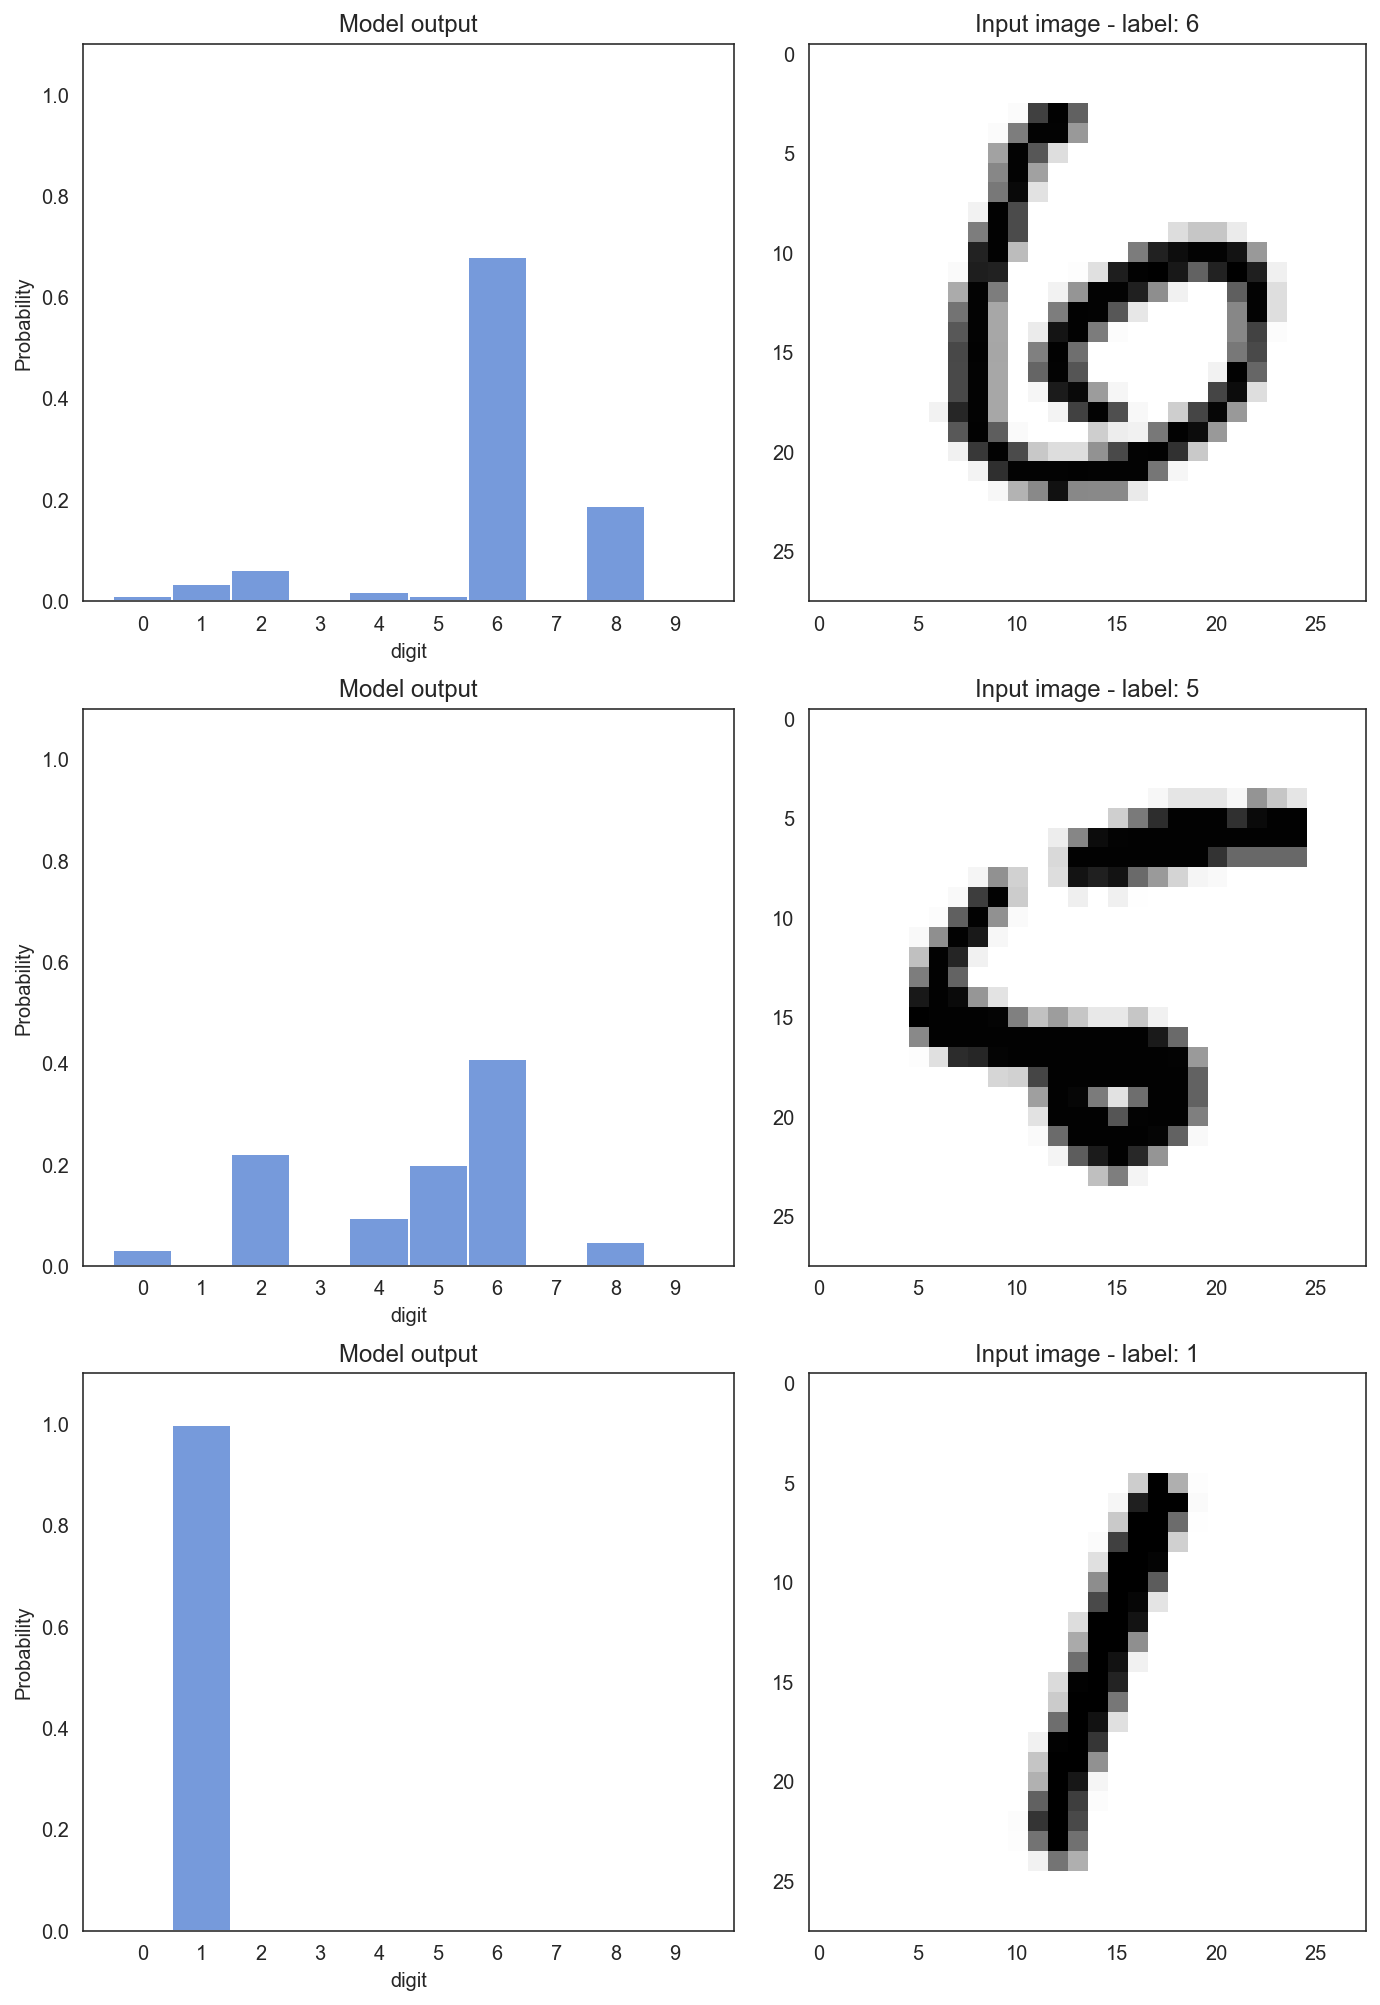

In [169]:
idx = 11
fig, ax = plt.subplots(3,2, figsize=(10, 14))

for n, idx in enumerate([11,8,5]):
    sns.histplot(ppc["out"][:, idx], stat="probability", color="C0", bins=np.arange(10)-0.5, ax=ax[n, 0])
    ax[n, 0].set_ylim(0,1.1)
    ax[n, 0].set_xlim(-1, 10)
    ax[n, 0].set_xticks(np.arange(10))
    ax[n, 0].set_xlabel("digit")
    ax[n, 0].set_title("Model output")
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax[n, 1].set_aspect(asp)
    ax[n, 1].imshow(X_test[idx].reshape(28,28), cmap="Greys")
    ax[n, 1].set_title(f"Input image - label: {int(Y_test[idx])}")
    
fig.tight_layout()
    #plt.savefig("BNN_pred.svg")

We can now see the advantage of BNNs over traditional NNs. While a traditional NN will yield one output and one output only (deterministic) a BNN yields multiple (potentially different outputs) representing the internal "state-of-belief" of the BNN which in some way more accuractely reflects our human brain. The model's uncertainty is reflected by a dispersion of probability mass. If the probability mass is very concentrated on a single digit (e.g. the last row) the model is very sure about it's output, while the distribution of probability mass over many digits (e.g. the middle row) indicates uncertainty of the model. This additional information about the model's output is a big advantage over the "black-box" traditional NNs.